## Genetics of BW-derived traits

### Load preamable

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Arial"

os.chdir("../")
sys.path.append(os.getcwd())

In [3]:
def save_figure(fdir, fname):

  # save figure
  ftypes = ['.pdf']
  os.makedirs(fdir, exist_ok=True)
  for ftype in ftypes:
    plt.savefig(os.path.join(fdir, fname + ftype),
                bbox_inches='tight',
                dpi=300)
  return

In [4]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

# Hex color codes
diet_colors = []
hex_codes = {"AL": "#8B8682", "1D": "#87CEEB", "2D": "#27408B", "20": "#FFA500", "40": "#B22222"}
diet_colors = []
for key, value in hex_codes.items():
  rgb_tuple = tuple(int(value[i:i+2], 16) / 255 for i in (1, 3, 5))
  diet_colors.append(sns.set_hls_values(rgb_tuple))

sns.set_palette(diet_colors)
sns.color_palette()

[(0.5450980392156861, 0.5254901960784314, 0.5098039215686274),
 (0.5294117647058822, 0.8078431372549019, 0.9215686274509804),
 (0.15294117647058825, 0.25098039215686263, 0.5450980392156862),
 (1.0, 0.6470588235294118, 0.0),
 (0.6980392156862745, 0.1333333333333333, 0.1333333333333333)]

### Load data

In [5]:
H2_MODEL_DIR = "data/heritability"
GWAS_MODEL_DIR = "data/gwas"
METHOD = "gxemm"
APPROX = True

### Heritability

In [6]:
def heritability_forest_plot(increase_ls,
                             decrease_ls,
                             mode='prepost',
                             model_dir=H2_MODEL_DIR,
                             save=False,
                             fname=None):


  def extract_heritability(mode,
                           model_dir,
                           phenotype,
                           agebin,
                           weighted,
                           transform,
                           event,
                           outlier):

    # diet groups
    diets = ["AL", "1D", "2D", "20", "40"]
    diets = ['TO'] + diets

    # if mode is prepost
    cnames = []
    if mode == "prepost":
      cnames.append(agebin + '.' + phenotype.replace('_', '.') + '.' + event)

    if weighted and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                   'max_bodyweight', 'min_bodyweight',
                                   'max_growthrate', 'min_growthrate',
                                   'max_abs_growthrate', 'state_occupancy',
                                   'state_transitions', 'max_abs_growthrate_percent']):
      cnames = ["weighted." + c for c in cnames]

    he = []
    se = []

    # extract effect size and standard errors
    for d, diet in enumerate(diets):

      if diet == 'TO':
        colname = 'total'
      else:
        colname = diet

      for c, cname in enumerate(cnames):

        # create file
        cached_csvname = f'{model_dir}/{cname}.csv'
        if transform in ["logit", "log", "sqrt", "rankint"]:
          if outlier:
            cached_csvname = f'{model_dir}/outlier.{transform}.{cname}.csv'
          else:
            cached_csvname = f'{model_dir}/{transform}.{cname}.csv'
        else:
          if outlier:
            cached_csvname = f'{model_dir}/outlier.{cname}.csv'

        if outlier and (phenotype in ['state_occupancy', 'state_transitions',
                                      'avg_growthrate', 'max_abs_growthrate',
                                      'longest_bout_survival',
                                      'start_time_longest_bout_survival',
                                      'longest_bout', 'start_time_longest_bout']):
          cached_csvname = "outlier." + cached_csvname

        if os.path.isfile(cached_csvname):
          df = pd.read_csv(cached_csvname, sep=',', index_col=0)
          he.append(df.loc[cname, colname+'.pve'])
          se.append(df.loc[cname, colname+'.pve.serr'])

        else:
          he.append(np.nan)
          se.append(np.nan)

    return (he, se)

  # states
  state_names = ['DS', 'SS', 'GS']
  full_state_names = ["decline", "steady", "growth"]
  lifespan_lists = [increase_ls, decrease_ls]
  phenotype_names = {
      'state_occupancy': "state occupancy",
      'state_transitions': "state transitions",
      'longest_bout': "longest bout",
      'start_time_longest_bout': "start time of the longest bout",
      'max_abs_growthrate': "max absolute rate",
      'max_abs_growthrate_percent': "normalized max absolute rate"
  }
  titles = ["traits assoicated with increasing lifespan",
            "traits associated with decreasing lifespan"]

  diets = ["AL", "1D", "2D", "20", "40"]
  diets = ['TO'] + diets
  d_colors = ['black'] + diet_colors

  # figure properties
  fig, axs = plt.subplots(figsize=(24, 6), nrows=1, ncols=len(lifespan_lists),
                          sharey=False, sharex=True)
  axs = axs.ravel()
  sns.set(font_scale=1.01)
  sns.set_style("white")
  sns.set_context("talk")

  ishift = np.linspace(-1, 1, len(diets))

  for p, phenotype_list in enumerate(lifespan_lists):
    ax = axs[p]
    yticklabels = []
    max_yshift = np.max([len(lifespan_lists[0]),
                         len(lifespan_lists[1])])
    yshift = 3*np.arange(0, max_yshift)
    yshift = yshift[:len(lifespan_lists[p])]

    for q, phenotype in enumerate(phenotype_list):
      he, se = extract_heritability(mode=mode,
                                    model_dir=model_dir,
                                    phenotype=phenotype[0],
                                    agebin=phenotype[1],
                                    weighted=phenotype[2],
                                    transform=phenotype[3],
                                    event=phenotype[5],
                                    outlier=phenotype[4])
      event = phenotype[5]
      if phenotype[0] != 'state_transitions':
        txt = phenotype_names[phenotype[0]] + "\n" + "in " + \
        full_state_names[state_names.index(event)] + " state"
      else:
        txt = phenotype_names[phenotype[0]] + " from " + "\n" + \
              full_state_names[state_names.index(event.split('.')[1])] + ' to ' + \
              full_state_names[state_names.index(event.split('.')[0])] + " state"
      yticklabels.append(txt)

      for i, diet in enumerate(diets):

        ax.errorbar(y=yshift[q] + ishift[i],
                    x=np.array(he[i]),
                    xerr=np.array(se[i]),
                    marker='o',
                    ms=10,
                    color=d_colors[i],
                    capsize=5,
                    mec=d_colors[i],
                    linewidth=4,
                    mfc='white',
                    ls='none')
      ax.plot([0., 0.7],
              [yshift[q] + 1.5, yshift[q] + 1.5],
              color='gray', linewidth=1.5,
              linestyle='dotted')

    ax.axvline(x=0.23, color='gray', linewidth=1.5, linestyle='dotted')
    ax.axvspan(xmin=0.106, xmax=0.360, color='gray', alpha=0.2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    ax.set_yticks(yshift)
    ax.set_yticklabels(yticklabels, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel("heritability", fontsize=20)
    ax.set_ylim([0+ishift[0]-0.5, 3*max_yshift+0.0])


  handles = [
      Line2D(
          [], [],
          c=color,
          lw=4,
          marker="o",
          markersize=12,
          label=species,
          mfc='white'
      )
      for species, color in zip(reversed(diets), reversed(diet_colors))
  ]

  legend = ax.legend(
      handles=handles,
      loc=(1, 0),       # bottom-right
      labelspacing=0.5, # add space between labels
      frameon=False     # don't put a frame
  )

  # Iterate through text elements and change their properties
  for text in legend.get_texts():
    text.set_fontsize(16)

  plt.subplots_adjust(hspace=0.1, wspace=0.6)

  # save figure
  if save and (fname is not None):
    save_figure(fdir="images",
                fname=fname)

  plt.show()

  return

#### Associated with increasing/decreasing lifespan

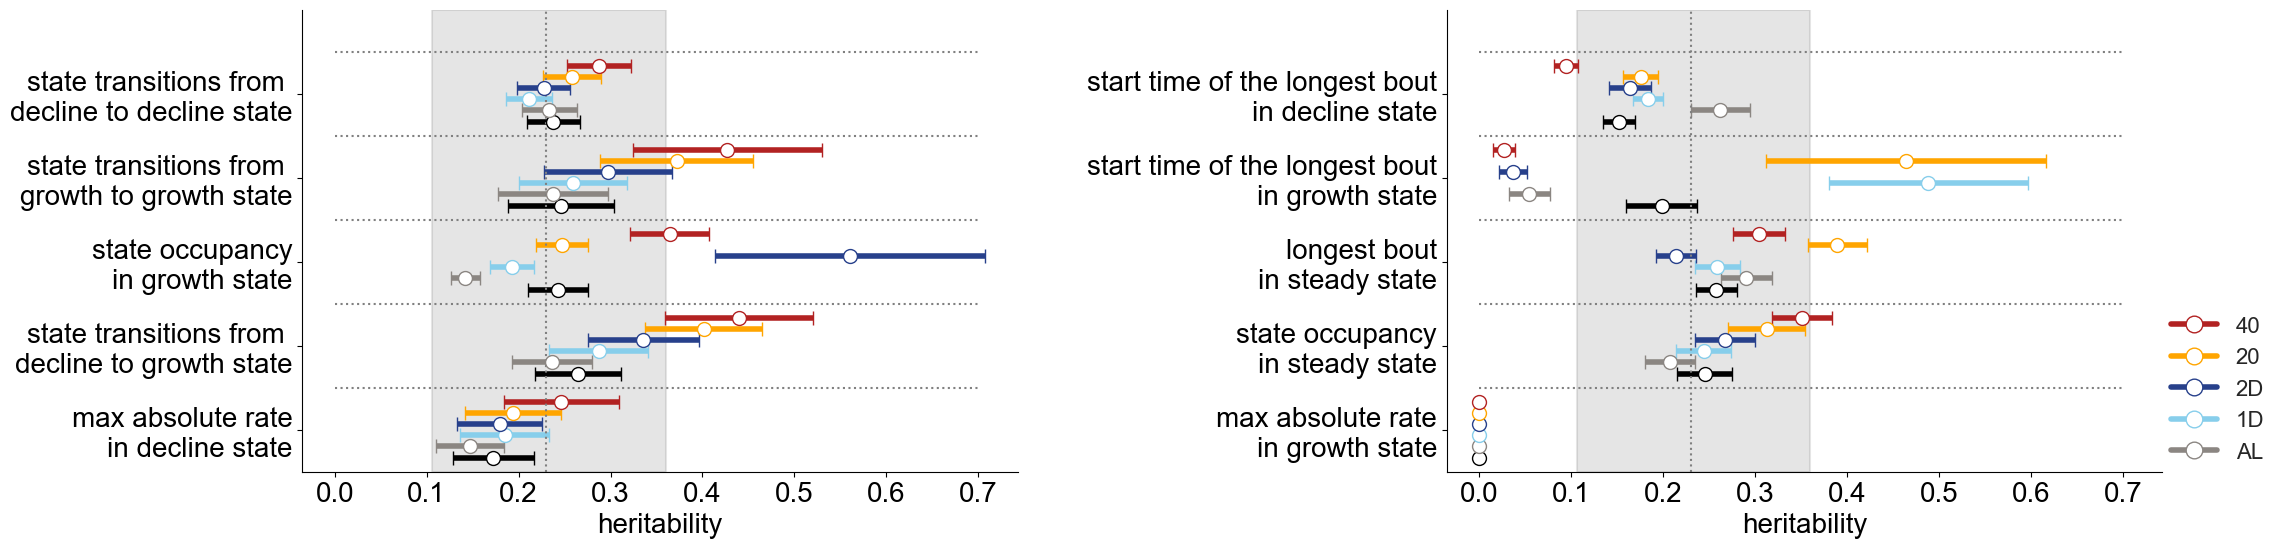

In [7]:
# format of phenotype list
# ["phenotype", "mode", "weighted", "transform", "outlier", "event"]

increase_ls = [
    ['max_abs_growthrate', 'post', True, "rankint", False, 'GS'],
    ['state_occupancy', 'post', True, "rankint", False, 'SS'],
    ['longest_bout', 'post', False, "rankint", False, 'SS'],
    ['start_time_longest_bout', 'post', False, "rankint", False, 'GS'],
    ['start_time_longest_bout', 'post', False, "rankint", False, 'DS'],

]

decrease_ls = [
    ['max_abs_growthrate', 'post', True, "rankint", False, 'DS'],
    ['state_transitions', 'post', True, "rankint", False, 'GS.DS'],
    ['state_occupancy', 'post', True, "rankint", False, 'GS'],
    ['state_transitions', 'post', True, "rankint", False, 'GS.GS'],
    ['state_transitions', 'post', True, "rankint", False, 'DS.DS'],
]

heritability_forest_plot(decrease_ls, increase_ls, save=False, fname='forest_plot')

### GWAS

In [8]:
def manhattan_plots(mode="timeint",
                    model_dir=GWAS_MODEL_DIR,
                    compress=False,
                    approx=APPROX,
                    method=METHOD,
                    weighted=[False],
                    flip_weighted=None,
                    transform=False,
                    outlier=False,
                    phenotypes=['state_occupancy'],
                    events=['SS'],
                    flip_phenotypes=None,
                    flip_events=None,
                    model_type='additive',
                    save=False,
                    filename=None):
  
  # chromosome lengths
  chromosome_lengths = [8402, 8524, 6323, 6492, 6491, 6319,
                      6189, 5593, 5785, 5331, 6253, 5110,
                      5189, 4931, 4490, 4287, 4245, 3939,
                      3060, 3854]

  # figure properties
  if compress and (flip_phenotypes is None):
    fig, axs = plt.subplots(figsize=(25, 2.75), nrows=1, ncols=1, sharey=True)
    sns.set(font_scale=1.01)
    sns.set_style("white")
    sns.set_context("talk")
    axs = [axs]
    colors = sns.color_palette("tab10", n_colors=12)

  if compress and (flip_phenotypes is not None):
    fig, axs = plt.subplots(figsize=(25, 6.5), nrows=2, ncols=1, sharex=True)
    axs = axs.ravel()
    sns.set(font_scale=1.01)
    sns.set_style("white")
    sns.set_context("talk")
    colors = sns.color_palette("tab10", n_colors=12)

  # list of chromosomes
  chromosomes = [str(i) for i in np.arange(1, 20, 1)]
  chromosomes = chromosomes + ['X']

  # min and max age in days
  min_age_days = 30
  max_age_days = 1080
  interval = 180

  # time inervals
  time_intervals = [t1 for t1 in np.arange(0,
                                           max_age_days + 1,
                                           interval)]

  # interventions
  interventions = ["post"]
  label_phenotype = []
  label_event = []
  label_color = []

  state_names = ['DS', 'SS', 'GS']
  full_state_names = ["decline", "steady", "growth"]
  phenotype_names = {
      'state_occupancy': "state occupancy",
      'state_transitions': "state transitions",
      'longest_bout': "longest bout",
      'start_time_longest_bout': "start time of the longest bout",
      'max_abs_growthrate': "max absolute rate",
      'max_abs_growthrate_percent': "normalized max absolute rate"
  }

  for q, (phenotype, event) in enumerate(zip(phenotypes, events)):

    # generate cnames
    cnames = []

    if mode == "timeint":
      for t, ti in enumerate(time_intervals[:-1]):
        name = phenotype.replace('_', '.') + '.' + \
                str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                '.' + event
        cnames.append(name)
    elif mode == "prepost":
      for i, inter in enumerate(interventions):
        name = inter + '.' + phenotype.replace('_', '.') + '.' + event
        cnames.append(name)


    if weighted[q] and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                    'max_bodyweight', 'min_bodyweight',
                                    'max_growthrate', 'min_growthrate',
                                    'max_abs_growthrate', 'state_occupancy',
                                    'avg_rmse_bodyweight', 'state_transitions',
                                    'max_abs_growthrate_percent']):
      cnames = ["weighted." + c for c in cnames]

    xshift = 0
    pad = 2000

    add_threshold = -np.log10(6.30*1e-05)
    int_threhsold = -np.log10(6.30*1e-05)

    for c, cname in enumerate(cnames):

      add_pvals = []
      int_pvals = []

      # if transform
      fname = cname
      if transform in ["logit", "log", "sqrt", "rankint"]:
        fname = transform + "." + cname
        if outlier:
          fname = "outlier." + transform + "." + cname
      else:
        if outlier:
          fname = "outlier." + cname

      # check if approx model
      if approx:
        cname_dir = os.path.join(model_dir, method + '_approx', fname)
      else:
        cname_dir = os.path.join(model_dir, method, fname)

      print(cname_dir)
      for ch, chromosome in enumerate(chromosomes):

        # cached csvname
        cached_csvname = os.path.join(cname_dir, 'gwas_chr_' + chromosome + '.csv')

        # load pvals
        if os.path.isfile(cached_csvname):
          df_chr = pd.read_csv(cached_csvname, sep=',')
          add_pvals.append(df_chr["additive.p.value"].to_numpy())
          int_pvals.append(df_chr["interaction.p.value"].to_numpy())
        else:
          tmp = np.zeros((chromosome_lengths[ch], ))
          tmp[:] = np.nan
          add_pvals.append(tmp)
          int_pvals.append(tmp)

      # manhattan plot
      for a, ax in enumerate([axs[0]]):

        xticks = []

        # reset xshift
        xshift = 0

        if model_type == 'additive':
          pvals = add_pvals
        elif model_type == 'interactive':
          pvals = int_pvals

        for p, pval in enumerate(pvals):
          x_range = np.arange(0, len(pval))

          # choose threshold
          if model_type == 'additive':
            pval_threshold = add_threshold
          elif model_type == 'interactive':
            pval_threshold = int_threhsold

          # choose alpha
          if np.mod(p, 2) == 0:
            alpha = 0.05
          else:
            alpha = 0.08

          # mask significant
          # if np.sum(np.isfinite(pval)) != 0:
          minuslog10pval = -np.log10(pval)
          mask =  minuslog10pval > pval_threshold

          # scatter plot
          ax.scatter(x_range[mask] + xshift, minuslog10pval[mask], s=30,
                    c=np.array([colors[q]]), rasterized=True)
          ax.scatter(x_range[~mask] + xshift, minuslog10pval[~mask], s=1,
                    c="w", edgecolor="gray", alpha=alpha, rasterized=True)

          if np.sum(mask) != 0:
            label_phenotype.append(phenotype)
            label_event.append(event)
            label_color.append(colors[q])


          # update xshift
          if p == 0:
            xticks.append((len(pval) // 2))
          else:
            xticks.append((len(pval) // 2) + xshift)
          xshift = pad + xshift + len(pval)


  # ax.tick_params(axis='y', which='major', left=True, labelsize=18)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(True)
  # ax.set_ylabel('$-\log_{10}(p)$', fontsize=20)


  ax.axhline(y=add_threshold, xmin=0, xmax=xshift-pad, linestyle='--', color='red',
             linewidth=2, rasterized=True)
  ax.annotate(r"$\alpha = 0.05$", (-4000, add_threshold-0.55), fontsize=16)

  for c, chromosome in enumerate(chromosomes):
    ax.annotate(chromosome, (xticks[c], -1), fontsize=16)

  # ax.set_xticks(np.array(xticks))
  # ax.set_xticklabels(chromosomes, fontsize=20)
  # ax.tick_params(axis='x', which='major', bottom=True, labelsize=20)
  ax.tick_params(axis='y', which='major', left=True, labelsize=20)
  ax.set_ylim([0, 6])

  # ax.set_xlabel("Chromosome", fontsize=20)

  for (phenotype, event, color) in zip(label_phenotype, label_event, label_color):
    if phenotype != 'state_transitions':
      txt = phenotype_names[phenotype] + "\n" + "in " + \
      full_state_names[state_names.index(event)] + " state"
    else:
      txt = phenotype_names[phenotype] + " from " + "\n" + \
            full_state_names[state_names.index(event.split('.')[1])] + ' to ' + \
            full_state_names[state_names.index(event.split('.')[0])] + " state"
    ax.scatter([], [], s=20, c=np.array([color]), label=txt)

  ax.legend(frameon=True, loc="upper center",
            ncol=len(label_phenotype),
            # bbox_to_anchor=(0.25, 0.8, 1.25, 0.5),
            bbox_to_anchor=(0.5, 1.42),
            fontsize=18)


  #############################################################################
  #############################################################################
  if len(axs) > 1:
    print("Flip phenotypes ....")
    label_phenotype = []
    label_event = []
    label_color = []

    for q, (phenotype, event) in enumerate(zip(flip_phenotypes, flip_events)):

      # generate cnames
      cnames = []

      if mode == "timeint":
        for t, ti in enumerate(time_intervals[:-1]):
          name = phenotype.replace('_', '.') + '.' + \
                  str(time_intervals[t]) + '.to.' + str(time_intervals[t+1]) + \
                  '.' + event
          cnames.append(name)
      elif mode == "prepost":
        for i, inter in enumerate(interventions):
          name = inter + '.' + phenotype.replace('_', '.') + '.' + event
          cnames.append(name)


      if flip_weighted[q] and (phenotype in ['avg_bodyweight', 'avg_growthrate',
                                      'max_bodyweight', 'min_bodyweight',
                                      'max_growthrate', 'min_growthrate',
                                      'max_abs_growthrate', 'state_occupancy',
                                      'avg_rmse_bodyweight', 'state_transitions',
                                      'max_abs_growthrate_percent']):
        cnames = ["weighted." + c for c in cnames]

      xshift = 0
      pad = 2000
      add_threshold = -np.log10(6.30*1e-5)

      for c, cname in enumerate(cnames):

        add_pvals = []
        int_pvals = []

        # if transform
        fname = cname
        if transform in ["logit", "log", "sqrt", "rankint"]:
          fname = transform + "." + cname
          if outlier:
            fname = "outlier." + transform + "." + cname
        else:
          if outlier:
            fname = "outlier." + cname

        # check if approx model
        if approx:
          cname_dir = os.path.join(model_dir, method + '_approx', fname)
        else:
          cname_dir = os.path.join(model_dir, method, fname)

        print(cname_dir)
        for ch, chromosome in enumerate(chromosomes):

          # cached csvname
          cached_csvname = os.path.join(cname_dir, 'gwas_chr_' + chromosome + '.csv')

          # load pvals
          if os.path.isfile(cached_csvname):
            df_chr = pd.read_csv(cached_csvname, sep=',')
            add_pvals.append(df_chr["additive.p.value"].to_numpy())
            int_pvals.append(df_chr["interaction.p.value"].to_numpy())
          else:
            tmp = np.zeros((chromosome_lengths[ch], ))
            tmp[:] = np.nan
            add_pvals.append(tmp)
            int_pvals.append(tmp)

        # manhattan plot
        for a, ax in enumerate([axs[1]]):

          xticks = []

          # reset xshift
          xshift = 0

          if model_type == 'additive':
            pvals = add_pvals
          elif model_type == 'interactive':
            pvals = int_pvals

          for p, pval in enumerate(pvals):
            x_range = np.arange(0, len(pval))

            # choose threshold
            if model_type == 'additive':
              pval_threshold = add_threshold
            elif model_type == 'interactive':
              pval_threshold = int_threhsold

            # choose alpha
            if np.mod(p, 2) == 0:
              alpha = 0.05
            else:
              alpha = 0.08

            # mask significant
            minuslog10pval = -np.log10(pval)
            mask =  minuslog10pval > pval_threshold

            # scatter plot
            ax.scatter(x_range[mask] + xshift, -minuslog10pval[mask], s=30,
                      c=np.array([colors[q]]), rasterized=True)
            ax.scatter(x_range[~mask] + xshift, -minuslog10pval[~mask], s=1,
                      c="w", edgecolor="gray", alpha=alpha, rasterized=True)

            if np.sum(mask) != 0:
              if not((phenotype in label_phenotype) and (event in label_event)):
                label_phenotype.append(phenotype)
                label_event.append(event)
                label_color.append(colors[q])


            # update xshift
            if p == 0:
              xticks.append((len(pval) // 2))
            else:
              xticks.append((len(pval) // 2) + xshift)
            xshift = pad + xshift + len(pval)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.set_ylim([-6, 0])

    ax.axhline(y=-add_threshold, xmin=0, xmax=xshift-pad, linestyle='--', color='red',
              linewidth=2, rasterized=True)
    ax.annotate(r"$\alpha = 0.05$", (-4000, -add_threshold-0.6), fontsize=16)

    for c, chromosome in enumerate(chromosomes):
      ax.annotate(chromosome, (xticks[c], 0.4), fontsize=16, annotation_clip=False, ha="center")
    ax.annotate(r"$- \log_{10} (p)$", (-12000, -1), fontsize=16, rotation=90, annotation_clip=False, ha="center")


    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(6,-1,-2))
    ax.tick_params(axis='y', which='major', left=True, labelsize=20)


    for (phenotype, event, color) in zip(label_phenotype, label_event, label_color):
      if phenotype != 'state_transitions':
        txt = phenotype_names[phenotype] + "\n" + "in " + \
        full_state_names[state_names.index(event)] + " state"
      else:
        txt = phenotype_names[phenotype] + " from " + "\n" + \
              full_state_names[state_names.index(event.split('.')[1])] + ' to ' + \
              full_state_names[state_names.index(event.split('.')[0])] + " state"
      ax.scatter([], [], s=20, c=np.array([color]), label=txt)

    ax.legend(frameon=True, loc="lower center",
              ncol=len(label_phenotype),
              # bbox_to_anchor=(0.25, 0.8, 1.25, 0.5),
              bbox_to_anchor=(0.5, -0.45),
              fontsize=18)

  if save and (filename is not None):
    save_figure(fdir='figure6',
                fname=filename)

  plt.show()

  return

#### Associated with increasing/decreasing lifespan

data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.SS.SS
data/gwas/gxemm_approx/rankint.weighted.post.max.abs.growthrate.GS
data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.SS.GS
data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.SS.DS
data/gwas/gxemm_approx/rankint.weighted.post.state.occupancy.SS
data/gwas/gxemm_approx/rankint.post.longest.bout.SS
data/gwas/gxemm_approx/rankint.post.start.time.longest.bout.GS
data/gwas/gxemm_approx/rankint.post.start.time.longest.bout.DS
Flip phenotypes ....
data/gwas/gxemm_approx/rankint.weighted.post.max.abs.growthrate.DS
data/gwas/gxemm_approx/rankint.weighted.post.state.occupancy.DS
data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.DS.SS
data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.DS.GS
data/gwas/gxemm_approx/rankint.weighted.post.state.transitions.GS.DS
data/gwas/gxemm_approx/rankint.weighted.post.state.occupancy.GS
data/gwas/gxemm_approx/rankint.weighted.post.state.transition

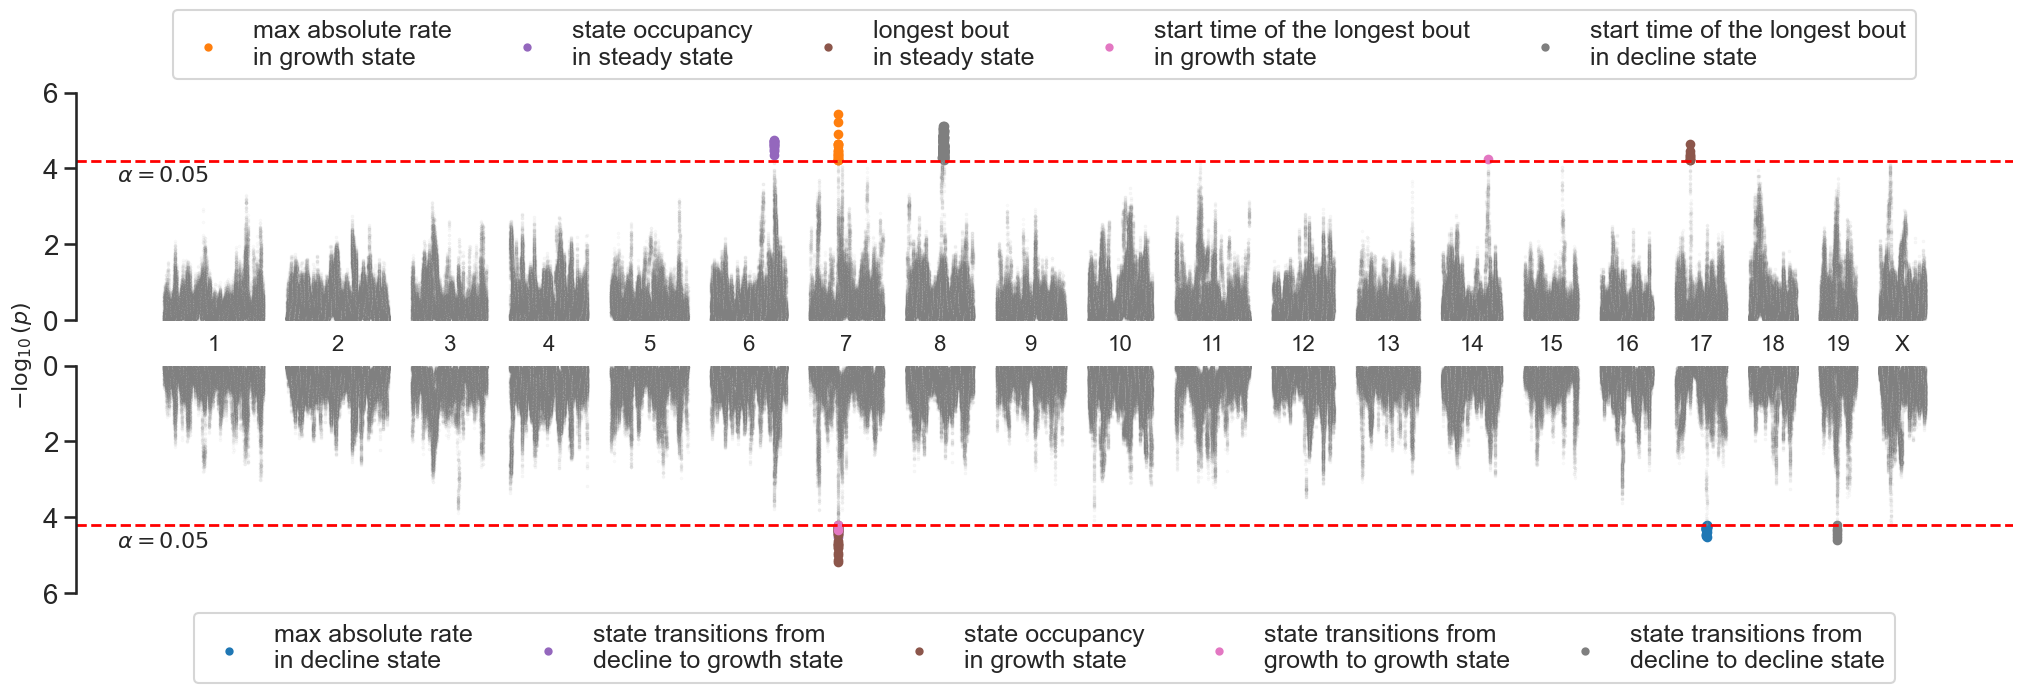

In [9]:
increasing_ls_traits = ['state_transitions', 'max_abs_growthrate', 'state_transitions', 'state_transitions', 'state_occupancy', 'longest_bout', 'start_time_longest_bout', 'start_time_longest_bout']
increasing_ls_events = ['SS.SS', 'GS', 'SS.GS', 'SS.DS', 'SS', 'SS', 'GS', 'DS']
increasing_ls_weight = [True, True, True, True, True, False, False, False]

decreasing_ls_traits = ['max_abs_growthrate', 'state_occupancy', 'state_transitions', 'state_transitions', 'state_transitions', 'state_occupancy', 'state_transitions', 'state_transitions']
decreasing_ls_events = ['DS', 'DS', 'DS.SS', 'DS.GS', 'GS.DS', 'GS', 'GS.GS', 'DS.DS']
decreasing_ls_weight = [True, True, True, True, True, True, True, True]

manhattan_plots(mode="prepost",
                compress=True,
                approx=APPROX,
                method=METHOD,
                transform="rankint",
                outlier=False,
                phenotypes=increasing_ls_traits,
                events=increasing_ls_events,
                weighted=increasing_ls_weight,
                flip_phenotypes=decreasing_ls_traits,
                flip_events=decreasing_ls_events,
                flip_weighted=decreasing_ls_weight,
                model_type='additive',
                save=False,
                filename='miami_plot')